# 1. Prueba - Data Augmentation 1 file

In [1]:
import os
import csv

In [3]:


# Set the directory path
#image_dir = 'ANPR2.v1i.yolov8/train_del/images'
image_dir = 'Peru Plate Numbers.v3i.yolov8/train_del/images'

# Supported image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')

# Get list of image file names
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_extensions)]

# Write to CSV
with open('image_files.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    for filename in image_files:
        writer.writerow([filename])


# 2. Aplicar format COCO 

## 2.1 Limpiar JSON

In [7]:
import json
import os
from pathlib import Path
from shutil import copyfile

In [8]:
def filter_coco_by_images(coco_path, image_dir, output_path):
    with open(coco_path, 'r') as f:
        data = json.load(f)

    valid_filenames = {f.name for f in Path(image_dir).glob("*")}
    image_id_map = {
        img['id']: img for img in data['images']
        if img['file_name'] in valid_filenames
    }

    data['images'] = list(image_id_map.values())
    valid_ids = set(image_id_map.keys())
    data['annotations'] = [
        ann for ann in data['annotations'] if ann['image_id'] in valid_ids
    ]

    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved filtered annotations to {output_path}")

def check_duplicate_filenames(*dirs):
    seen = {}
    duplicates = []

    for dir_path in dirs:
        for img_file in Path(dir_path).glob("*"):
            fname = img_file.name
            if fname in seen:
                duplicates.append((fname, seen[fname], dir_path))
            else:
                seen[fname] = dir_path

    if duplicates:
        print("Duplicate image filenames found:")
        for fname, dir1, dir2 in duplicates:
            print(f"{fname} found in:\n - {dir1}\n - {dir2}\n")
    else:
        print("No duplicate image filenames found.")



In [ ]:
# Paths
image_dir_1 = Path("Peru Plate Numbers.v3i.yolov8/train_filter_v7/images")
image_dir_2 = Path("ANPR2.v1i.yolov8/train_stage7_options/images")
coco_1_train = Path("Peru Plate Numbers.v3i.coco/train/_annotations.coco.json")
coco_2_train = Path("ANPR2.v1i.coco/train/_annotations.coco.json")
test_valid_dirs = [
    "Peru Plate Numbers.v3i.coco/test",
    "Peru Plate Numbers.v3i.coco/valid",
    "ANPR2.v1i.coco/test",
    "ANPR2.v1i.coco/valid"
]
check_duplicate_filenames(image_dir_1, image_dir_2, *test_valid_dirs)

In [25]:
coco_1_train = Path("Peru Plate Numbers.v3i.yolov8/train_filter_v8/instances_default.json")
image_dir_1 = Path("Peru Plate Numbers.v3i.yolov8/train_filter_v8/images")
filter_coco_by_images(coco_1_train, image_dir_1, "json/PPN_train_coco_annotations.coco.json")

Saved filtered annotations to json/PPN_train_coco_annotations.coco.json


In [ ]:
image_dir_2 = Path("ANPR2.v1i.yolov8/train_stage7_options/images")
coco_2_train = Path("ANPR2.v1i.coco/train/_annotations.coco.json")
filter_coco_by_images(coco_2_train, image_dir_2, "ANPR2_train_coco_annotations.coco.json")

In [ ]:
coco_3 = Path("ANPR2.v1i.coco/test/_annotations.coco.json")
coco_4 = Path("ANPR2.v1i.coco/valid/_annotations.coco.json")
image_dir_3 = Path("ANPR2.v1i.yolov8/test_v2/images")
image_dir_4 = Path("ANPR2.v1i.yolov8/valid_v2/images")

filter_coco_by_images(coco_3, image_dir_3, "ANPR2_test_coco_annotations.coco.json")
filter_coco_by_images(coco_4, image_dir_4, "ANPR2_valid_coco_annotations.coco.json")

Saved filtered annotations to ANPR2_test_coco_annotations.coco.json
Saved filtered annotations to ANPR2_valid_coco_annotations.coco.json


In [26]:
coco_path = Path("Peru Plate Numbers.v3i.yolov8/test_v3/instances_default.json")
image_dir = Path("Peru Plate Numbers.v3i.yolov8/test_v3/images")
filter_coco_by_images(coco_path,image_dir,"json/PPN_test_coco_annotations.coco.json")

Saved filtered annotations to json/PPN_test_coco_annotations.coco.json


In [27]:
image_dir = Path("Peru Plate Numbers.v3i.yolov8/valid_v3/images")
coco_path = Path("Peru Plate Numbers.v3i.yolov8/valid_v3/instances_default.json")

filter_coco_by_images(coco_path,image_dir,"json/PPN_valid_coco_annotations.coco.json")

Saved filtered annotations to json/PPN_valid_coco_annotations.coco.json


## 2.2 Mostrar frecuencias de las categorias

In [9]:
import json
from collections import Counter

def display_category_frequencies_with_ids(annotation_path):
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    category_counts = Counter(ann['category_id'] for ann in data['annotations'])
    category_names = {cat['id']: cat['name'] for cat in data['categories']}

    print(f"Frequencies in {annotation_path}:")
    for cat_id, count in category_counts.items():
        name = category_names.get(cat_id, f"Unknown")
        print(f"  ID {cat_id} - {name}: {count}")
    print()

In [ ]:
display_category_frequencies_with_ids("PPN_train_coco_annotations.coco.json")
display_category_frequencies_with_ids("ANPR2_train_coco_annotations.coco.json")

Frequencies in PPN_coco_annotations.coco.json:
  ID 1 - Placa: 774
  ID 2 - placa: 137

Frequencies in ANPR2_coco_annotations.coco.json:
  ID 1 - placa: 679



## 2.3 Uniformizar "category"
{"id": 0, "name": "plate", "supercategory": "none"}

In [14]:
import json

def unify_category(annotation_path, output_path):
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    # Replace categories with a single one
    data['categories'] = [{"id": 0, "name": "plate", "supercategory": "none"}]

    # Set all annotations to category_id 0
    for ann in data['annotations']:
        ann['category_id'] = 0

    with open(output_path, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"Saved unified category annotations to {output_path}")




In [ ]:
unify_category("ANPR2_train_coco_annotations.coco.json", "ANPR2_fixed_train_coco_annotations.coco.json")

In [ ]:
unify_category("ANPR2_test_coco_annotations.coco.json", "ANPR2_fixed_test_coco_annotations.coco.json")
unify_category("ANPR2_valid_coco_annotations.coco.json", "ANPR2_fixed_valid_coco_annotations.coco.json")



Saved unified category annotations to ANPR2_fixed_test_coco_annotations.coco.json
Saved unified category annotations to ANPR2_fixed_valid_coco_annotations.coco.json
Saved unified category annotations to PPN_fixed_test_coco_annotations.coco.json
Saved unified category annotations to PPN_fixed_valid_coco_annotations.coco.json


In [28]:
unify_category("json/PPN_train_coco_annotations.coco.json", "json/PPN_fixed_train_coco_annotations.coco.json")

Saved unified category annotations to json/PPN_fixed_train_coco_annotations.coco.json


In [29]:
unify_category("json/PPN_valid_coco_annotations.coco.json", "json/PPN_fixed_valid_coco_annotations.coco.json")

Saved unified category annotations to json/PPN_fixed_valid_coco_annotations.coco.json


In [30]:
unify_category("json/PPN_test_coco_annotations.coco.json", "json/PPN_fixed_test_coco_annotations.coco.json")

Saved unified category annotations to json/PPN_fixed_test_coco_annotations.coco.json


## 2.4 Renombrar nombres de los archivos de imagen

In [20]:
import os
import json
import re
from pathlib import Path

def rename_images_and_update_coco(image_dir, coco_json_path, new_json_name):
    image_dir = Path(image_dir)
    coco_json_path = Path(coco_json_path)
    new_json_path = coco_json_path.parent / new_json_name

    # Load original JSON
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    # Build mapping from old name to new name using regex
    name_map = {}
    for img_file in image_dir.glob("*.*"):
        old_name = img_file.name
        base, ext = os.path.splitext(old_name)

        match = re.match(r"(.+?)_?(?:jpg|jpeg|png)?\.rf\.[^.]+", base)
        if not match:
            continue  # skip if pattern doesn't match

        new_stem = match.group(1)
        new_name = f"{new_stem}{ext}"
        name_map[old_name] = new_name

        # Rename file
        img_file.rename(image_dir / new_name)

    # Update JSON
    updated_coco = coco.copy()
    for img in updated_coco['images']:
        old_name = Path(img['file_name']).name
        if old_name in name_map:
            img['file_name'] = name_map[old_name]

    # Save updated JSON
    with open(new_json_path, 'w') as f:
        json.dump(updated_coco, f, indent=2)

    print(f"Renamed {len(name_map)} images and saved updated JSON to {new_json_path}")


In [8]:
rename_images_and_update_coco(
    image_dir="ANPR2.v1i.yolov8/train_stage8_options/images",
    coco_json_path="ANPR2_fixed_train_coco_annotations.coco.json",
    new_json_name="ANPR2_renamed_train_coco_annotations.coco.json"
)

Renamed 437 images and saved updated JSON to ANPR2_renamed_train_coco_annotations.coco.json


In [ ]:
rename_images_and_update_coco(
    image_dir="Peru Plate Numbers.v3i.yolov8/train_filter_v8/images",
    coco_json_path="PPN_fixed_train_coco_annotations.coco.json",
    new_json_name="PPN_renamed_train_coco_annotations.coco.json"
)

In [ ]:
rename_images_and_update_coco(
    image_dir="ANPR2.v1i.yolov8/test_v3/images",
    coco_json_path="ANPR2_fixed_test_coco_annotations.coco.json",
    new_json_name="ANPR2_renamed_test_coco_annotations.coco.json"
)

Renamed 49 images and saved updated JSON to PPN_renamed_test_coco_annotations.coco.json


In [ ]:
rename_images_and_update_coco(
    image_dir="ANPR2.v1i.yolov8/valid_v3/images",
    coco_json_path="ANPR2_fixed_valid_coco_annotations.coco.json",
    new_json_name="ANPR2_renamed_valid_coco_annotations.coco.json"
)

Renamed 123 images and saved updated JSON to PPN_renamed_valid_coco_annotations.coco.json


In [50]:
rename_images_and_update_coco(
    image_dir="Peru Plate Numbers.v3i.yolov8/test_v3/images",
    coco_json_path="PPN_fixed_test_coco_annotations.coco.json",
    new_json_name="PPN_renamed_test_coco_annotations.coco.json"
)

Renamed 29 images and saved updated JSON to PPN_renamed_test_coco_annotations.coco.json


In [55]:
rename_images_and_update_coco(
    image_dir="Peru Plate Numbers.v3i.yolov8/valid_v3/images",
    coco_json_path="PPN_fixed_valid_coco_annotations.coco.json",
    new_json_name="PPN_renamed_valid_coco_annotations.coco.json"
)

Renamed 133 images and saved updated JSON to PPN_renamed_valid_coco_annotations.coco.json


## 2.5 Ver repetidos en train

In [14]:
import json
from pathlib import Path

def find_repeated_filenames(json_path_1, json_path_2, output_txt_path):
    # Load both JSONs
    with open(json_path_1, 'r') as f1, open(json_path_2, 'r') as f2:
        coco1 = json.load(f1)
        coco2 = json.load(f2)

    # Extract image filenames
    filenames1 = {Path(img['file_name']).name for img in coco1['images']}
    filenames2 = {Path(img['file_name']).name for img in coco2['images']}

    # Find duplicates
    repeated = sorted(filenames1 & filenames2)

    # Write results to output file
    with open(output_txt_path, 'w') as out:
        for name in repeated:
            out.write(name + '\n')

    print(f"Found {len(repeated)} repeated filenames. Saved to {output_txt_path}")


In [15]:
find_repeated_filenames(
    json_path_1="ANPR2_renamed_train_coco_annotations.coco.json",
    json_path_2="PPN_renamed_train_coco_annotations.coco.json",
    output_txt_path="coco_repeated_filenames.txt"
)


Found 223 repeated filenames. Saved to coco_repeated_filenames.txt


## 2.6 Juntar unique train images

In [18]:
import json
import shutil
from pathlib import Path

def merge_coco_datasets(
    coco_json_1, coco_json_2,
    image_dir_1, image_dir_2,
    output_dir
):
    coco_json_1 = Path(coco_json_1)
    coco_json_2 = Path(coco_json_2)
    image_dir_1 = Path(image_dir_1)
    image_dir_2 = Path(image_dir_2)
    output_dir = Path(output_dir)
    output_img_dir = output_dir / "images"
    output_img_dir.mkdir(parents=True, exist_ok=True)

    # Load both COCO JSONs
    with open(coco_json_1) as f:
        coco1 = json.load(f)
    with open(coco_json_2) as f:
        coco2 = json.load(f)

    # Prepare new dataset structure
    merged = {
        "info": {"description": "Merged dataset"},
        "licenses": [],
        "categories": coco1["categories"],  # assuming same structure
        "images": [],
        "annotations": []
    }

    # Track image and annotation IDs
    image_id_map = {}
    annotation_id = 0
    image_id = 0
    used_filenames = set()

    def process_dataset(coco, image_dir, prefer=True):
        nonlocal image_id, annotation_id
        for img in coco['images']:
            fname = Path(img['file_name']).name
            if fname in used_filenames:
                continue  # Skip if already used (dataset1 takes priority)

            src = image_dir / fname
            if not src.exists():
                continue  # Skip if image file is missing

            # Copy image to new location
            dst = output_img_dir / fname
            shutil.copyfile(src, dst)

            # Map image_id
            new_img = {
                "id": image_id,
                "file_name": f"{fname}",
                "width": img['width'],
                "height": img['height']
            }
            image_id_map[img['id']] = image_id
            image_id += 1
            used_filenames.add(fname)
            merged["images"].append(new_img)

        for ann in coco['annotations']:
            old_id = ann['image_id']
            if old_id not in image_id_map:
                continue
            new_ann = {
                "id": annotation_id,
                "image_id": image_id_map[old_id],
                "category_id": ann['category_id'],
                "bbox": ann['bbox'],
                "iscrowd": ann.get('iscrowd', 0),
                "area": ann.get('area', ann['bbox'][2] * ann['bbox'][3])
            }
            annotation_id += 1
            merged["annotations"].append(new_ann)

    # Process dataset 1 first (takes priority on duplicates)
    process_dataset(coco1, image_dir_1, prefer=True)
    process_dataset(coco2, image_dir_2, prefer=False)

    # Save final merged annotations
    output_json_path = output_dir / "_annotations.coco.json"
    with open(output_json_path, "w") as f:
        json.dump(merged, f, indent=2)

    print(f"Merged dataset saved to {output_dir}")


In [31]:
merge_coco_datasets(
    coco_json_1="json/PPN_renamed_train_coco_annotations.coco.json",
    coco_json_2="json/ANPR2_renamed_train_coco_annotations.coco.json",
    image_dir_1="Peru Plate Numbers.v3i.yolov8/train_filter_v8/images",
    image_dir_2="ANPR2.v1i.yolov8/train_stage8_options/images",
    output_dir="merged_train_dataset"
)

Merged dataset saved to merged_train_dataset


In [32]:
merge_coco_datasets(
    coco_json_1="json/PPN_renamed_test_coco_annotations.coco.json",
    coco_json_2="json/ANPR2_renamed_test_coco_annotations.coco.json",
    image_dir_1="Peru Plate Numbers.v3i.yolov8/test_v3/images",
    image_dir_2="ANPR2.v1i.yolov8/test_v3/images",
    output_dir="merged_test_dataset"
)

Merged dataset saved to merged_test_dataset


In [33]:
merge_coco_datasets(
    coco_json_1="json/PPN_renamed_valid_coco_annotations.coco.json",
    coco_json_2="json/ANPR2_renamed_valid_coco_annotations.coco.json",
    image_dir_1="Peru Plate Numbers.v3i.yolov8/valid_v3/images",
    image_dir_2="ANPR2.v1i.yolov8/valid_v3/images",
    output_dir="merged_valid_dataset"
)

Merged dataset saved to merged_valid_dataset


### 2.6.1 Total de imagenes

In [1]:
import os
from pathlib import Path

def count_images(path):
    image_extensions = {'.jpg', '.jpeg', '.png'}
    path = Path(path)
    count = sum(1 for f in path.iterdir() if f.suffix.lower() in image_extensions)
    print(f"Total images in '{path}': {count}")


In [36]:
count_images("merged_train_dataset/images")


Total images in 'merged_train_dataset\images': 664


In [37]:
count_images("Peru Plate Numbers.v3i.yolov8/train_filter_v8/images")
count_images("ANPR2.v1i.yolov8/train_stage8_options/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\train_filter_v8\images': 450
Total images in 'ANPR2.v1i.yolov8\train_stage8_options\images': 437


In [38]:
count_images("Peru Plate Numbers.v3i.yolov8/test/images")
count_images("ANPR2.v1i.yolov8/test/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\test\images': 32
Total images in 'ANPR2.v1i.yolov8\test\images': 53


In [39]:
count_images("Peru Plate Numbers.v3i.yolov8/test_v3/images")
count_images("ANPR2.v1i.yolov8/test_v3/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\test_v3\images': 29
Total images in 'ANPR2.v1i.yolov8\test_v3\images': 49


In [42]:
count_images("merged_test_dataset/images")

Total images in 'merged_test_dataset\images': 49


In [40]:
count_images("Peru Plate Numbers.v3i.yolov8/valid/images")
count_images("ANPR2.v1i.yolov8/valid/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\valid\images': 138
Total images in 'ANPR2.v1i.yolov8\valid\images': 128


In [41]:
count_images("Peru Plate Numbers.v3i.yolov8/valid_v3/images")
count_images("ANPR2.v1i.yolov8/valid_v3/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\valid_v3\images': 133
Total images in 'ANPR2.v1i.yolov8\valid_v3\images': 123


In [43]:
count_images("merged_valid_dataset/images")

Total images in 'merged_valid_dataset\images': 136


## 2.7 Unificar COCO JSON

In [44]:
import json
import shutil
from pathlib import Path

def unify_multiple_coco_datasets(dataset_paths, output_dir, repeated_txt_path):
    output_dir = Path(output_dir)
    output_images_dir = output_dir / "images"
    output_images_dir.mkdir(parents=True, exist_ok=True)
    repeated_txt_path = Path(repeated_txt_path)

    merged = {
        "info": {"description": "Unified dataset"},
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }

    image_id = 0
    annotation_id = 0
    used_filenames = set()
    repeated_files = []
    image_id_map = {}

    for dataset_path in dataset_paths:
        dataset_path = Path(dataset_path)
        coco_path = dataset_path / "_annotations.coco.json"
        images_path = dataset_path / "images"

        if not coco_path.exists() or not images_path.exists():
            print(f"Skipping {dataset_path} — missing annotations or images")
            continue

        with open(coco_path, 'r') as f:
            coco = json.load(f)

        # Set categories if not set yet
        if not merged["categories"]:
            merged["categories"] = coco["categories"]

        local_image_id_map = {}

        for img in coco["images"]:
            fname = Path(img["file_name"]).name
            if fname in used_filenames:
                repeated_files.append(fname)
                continue

            src_img_path = images_path / fname
            if not src_img_path.exists():
                continue

            dst_img_path = output_images_dir / fname
            shutil.copyfile(src_img_path, dst_img_path)

            merged["images"].append({
                "id": image_id,
                "file_name": f"{fname}",
                "width": img["width"],
                "height": img["height"]
            })

            local_image_id_map[img["id"]] = image_id
            used_filenames.add(fname)
            image_id += 1

        for ann in coco["annotations"]:
            old_img_id = ann["image_id"]
            if old_img_id not in local_image_id_map:
                continue

            merged["annotations"].append({
                "id": annotation_id,
                "image_id": local_image_id_map[old_img_id],
                "category_id": ann["category_id"],
                "bbox": ann["bbox"],
                "iscrowd": ann.get("iscrowd", 0),
                "area": ann.get("area", ann["bbox"][2] * ann["bbox"][3])
            })
            annotation_id += 1

    # Save merged annotation file
    with open(output_dir / "_annotations.coco.json", 'w') as f:
        json.dump(merged, f, indent=2)

    # Save repeated filenames
    with open(repeated_txt_path, 'w') as f:
        for fname in sorted(repeated_files):
            f.write(fname + '\n')

    print(f"Unified dataset saved to: {output_dir}")
    print(f"Repeated image names written to: {repeated_txt_path}")


In [45]:
unify_multiple_coco_datasets(
    dataset_paths=[
        "merged_train_dataset",
        "merged_test_dataset",
        "merged_valid_dataset"
    ],
    output_dir="unified_dataset",
    repeated_txt_path="unified_repeated_images.txt"
)


Unified dataset saved to: unified_dataset
Repeated image names written to: unified_repeated_images.txt


In [46]:
count_images("unified_dataset/images")

Total images in 'unified_dataset\images': 832


## 2.8 Visualizacion

In [47]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

In [50]:


def visualize_coco_bboxes(image_dir, annotation_file, num_images=4):
    """
    Display COCO bounding boxes for a few sample images.

    Parameters:
        image_dir (str): Path to the directory containing the images and annotation file.
        annotation_filename (str): COCO JSON annotation filename. Default is '_annotations.coco.json'.
        num_images (int): Number of images to display. Default is 4.
    """
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()[:num_images]

    rows = cols = int(num_images**0.5)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()

    for i, img_id in enumerate(image_ids):
        img_data = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_data['file_name'])
        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            x, y, w, h = ann['bbox']
            draw.rectangle([x, y, x + w, y + h], outline='red', width=10)

        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(img_data['file_name'])

    # Hide any unused subplots
    for j in range(len(image_ids), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


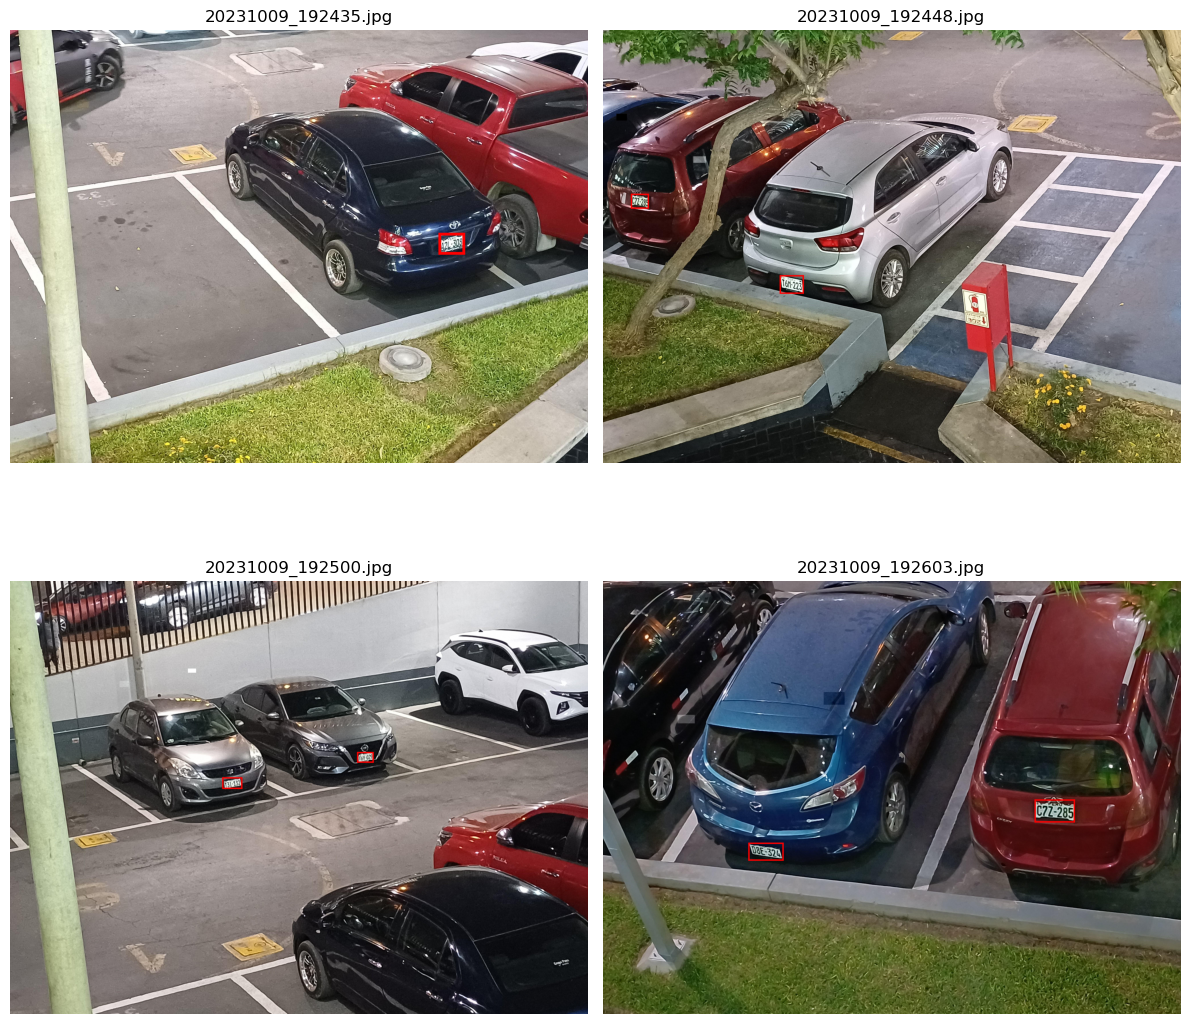

In [51]:
visualize_coco_bboxes("unified_dataset/images","unified_dataset/_annotations.coco.json")

# 2.9 Guardar imagenes con bbox

In [52]:
import os
from PIL import Image, ImageDraw
from pycocotools.coco import COCO

In [56]:


def save_coco_bboxes_to_images(image_dir, annotation_file, output_dir='output'):
    """
    Save images with bounding boxes drawn from COCO annotations.

    Parameters:
        image_dir (str): Directory containing the images.
        annotation_filename (str): Name of the COCO annotation file.
        output_dir (str): Directory to save output images with drawn bounding boxes.
    """
    os.makedirs(output_dir, exist_ok=True)
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()

    for img_id in image_ids:
        img_data = coco.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img_data['file_name'])
        output_path = os.path.join(output_dir, img_data['file_name'])

        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            x, y, w, h = ann['bbox']
            draw.rectangle([x, y, x + w, y + h], outline='red', width=3)

        image.save(output_path)


In [58]:
save_coco_bboxes_to_images(
    image_dir='unified_dataset/images',
    annotation_file='unified_dataset/_annotations.coco.json',
    output_dir='unified_dataset/images_bbox'
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# 2.10 Contar imagenes

In [ ]:
count_images("Peru Plate Numbers.v3i.yolov8/train_filter_v8/images")

Total images in 'Peru Plate Numbers.v3i.yolov8/train_filter_v8/images': 450


In [ ]:
count_images("Peru Plate Numbers.v3i.yolov8/valid_v3/images")

Total images in 'Peru Plate Numbers.v3i.yolov8/valid_v3/images': 133


In [59]:
count_images("Peru Plate Numbers.v3i.yolov8/test_v3/images")

Total images in 'Peru Plate Numbers.v3i.yolov8\test_v3\images': 29


In [2]:
count_images("unified_dataset/images")

Total images in 'unified_dataset\images': 832


In [3]:
count_images("unified_dataset/images_bbox")

Total images in 'unified_dataset\images_bbox': 832


# 2.11 Crear subsets

In [60]:
import os
import json
import random
from collections import defaultdict
from typing import Tuple

In [61]:
def split_dataset(
    images_path: str,
    coco_json_path: str,
    output_path: str,
    stratified: bool = True,
    split_ratio: Tuple[float, float, float] = (0.8, 0.1, 0.1)
):
    os.makedirs(output_path, exist_ok=True)

    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)

    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']

    image_id_to_image = {img['id']: img for img in images}
    image_id_to_annots = defaultdict(list)
    for ann in annotations:
        image_id_to_annots[ann['image_id']].append(ann)

    if stratified:
        image_id_to_categories = defaultdict(set)
        for ann in annotations:
            image_id_to_categories[ann['image_id']].add(ann['category_id'])

        category_to_image_ids = defaultdict(set)
        for img_id, cat_ids in image_id_to_categories.items():
            for cat_id in cat_ids:
                category_to_image_ids[cat_id].add(img_id)

        train_ids, valid_ids, test_ids = set(), set(), set()
        for cat_id, img_ids in category_to_image_ids.items():
            img_ids = list(img_ids)
            random.shuffle(img_ids)
            n = len(img_ids)
            n_train = int(n * split_ratio[0])
            n_valid = int(n * split_ratio[1])
            train_ids.update(img_ids[:n_train])
            valid_ids.update(img_ids[n_train:n_train + n_valid])
            test_ids.update(img_ids[n_train + n_valid:])
    else:
        all_image_ids = list(image_id_to_image.keys())
        random.shuffle(all_image_ids)
        n = len(all_image_ids)
        n_train = int(n * split_ratio[0])
        n_valid = int(n * split_ratio[1])
        train_ids = set(all_image_ids[:n_train])
        valid_ids = set(all_image_ids[n_train:n_train + n_valid])
        test_ids = set(all_image_ids[n_train + n_valid:])

    def save_subset(image_ids_set, filename):
        subset_images = [image_id_to_image[i] for i in image_ids_set]
        subset_annotations = [ann for ann in annotations if ann['image_id'] in image_ids_set]
        output_json = {
            'images': subset_images,
            'annotations': subset_annotations,
            'categories': categories
        }
        with open(os.path.join(output_path, filename), 'w', encoding='utf-8') as f:
            json.dump(output_json, f, indent=2)

    save_subset(train_ids, 'train.json')
    save_subset(valid_ids, 'valid.json')
    save_subset(test_ids, 'test.json')

    print(f"COCO JSONs saved to: {output_path} | Stratified: {stratified}")


In [63]:
split_dataset(
    images_path='unified_dataset/images',
    coco_json_path='unified_dataset/_annotations.coco.json',
    output_path='unified_dataset/subsets',
    stratified=False
)

COCO JSONs saved to: unified_dataset/subsets | Stratified: False


# 2.12 Verificacion de subsets

In [64]:

def count_images_per_category_in_jsons(input_path):
    """
    Reads all COCO-format JSON files in a directory and prints how many unique images are associated with each category.

    Parameters:
        input_path (str): Path to the directory containing COCO JSON files.
    """
    for file_name in os.listdir(input_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(input_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                coco = json.load(f)

            category_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}
            images_per_category = defaultdict(set)

            for annotation in coco['annotations']:
                category_id = annotation['category_id']
                image_id = annotation['image_id']
                images_per_category[category_id].add(image_id)

            print(f"\nFile: {file_name}")
            for category_id, image_ids in images_per_category.items():
                category_name = category_id_to_name.get(category_id, 'Unknown')
                print(f"- {category_name}: {len(image_ids)} images")


In [65]:
count_images_per_category_in_jsons('unified_dataset/subsets')


File: test.json
- plate: 84 images

File: train.json
- plate: 665 images

File: valid.json
- plate: 83 images
